# Lab 5 - Recurrent neural network
*by Yurii Voievidka*

![image](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)

LSTM Networks
Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

![image](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png)

Importing Libraries

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM, Activation, Dropout, Embedding, Input, Conv1D, MaxPooling1D
from keras.models import Model, Sequential
from keras.optimizers import RMSprop
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import pad_sequences

Read spam data

In [31]:
train_raw = pd.read_csv('./spam.csv', delimiter=',', encoding='latin-1')

In [32]:
train_raw.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [33]:
train_raw.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1, inplace=True)

In [34]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of ham and span messages')

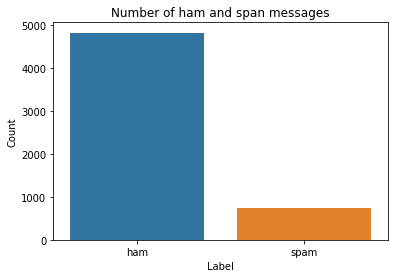

In [35]:
sns.countplot(train_raw.v1)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Number of ham and span messages')

In [36]:
X = train_raw.v2
Y = train_raw.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1, 1)

In [37]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.5)

In [38]:
print(y_train[:5])

[[0]
 [0]
 [0]
 [1]
 [0]]


Data Tokenizing

In [44]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(x_train)
sequences = tok.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences, maxlen=max_len)

In [45]:
def RNN():
  inputs = Input(name='inputs', shape=[max_len])
  model = Sequential([
      Input(name='inputs', shape=[max_len]),
      Embedding(max_words, 50, input_length=max_len),
      LSTM(64),
      Dense(256, name='FC1', activation='relu'),
      Dropout(0.5),
      Dense(1, name='out_layer', activation='sigmoid')
  ])
  return model

In [46]:
model = RNN()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_2 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257       
                                                                 
Total params: 96,337
Trainable params: 96,337
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [61]:

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001)
history = model.fit(sequences_matrix, y_train, batch_size=128, epochs=10, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
18/18 [==============================] - 8s 323ms/step - loss: 0.9357 - accuracy: 0.4998 - val_loss: 0.7283 - val_accuracy: 0.5165
Epoch 2/10
18/18 [==============================] - 4s 246ms/step - loss: 0.7049 - accuracy: 0.5320 - val_loss: 0.7072 - val_accuracy: 0.5196


In [51]:
test_sequences = tok.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

Testing RNN

In [52]:
accr = model.evaluate(test_sequences_matrix, y_test)

88/88 [==============================] - 5s 55ms/step - loss: 0.0670 - accuracy: 0.9803


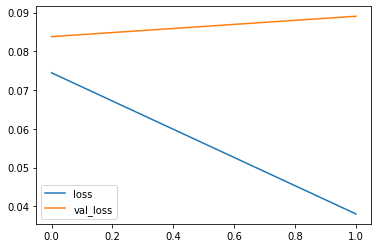

In [59]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

LSTM for sequence classification

In [53]:
from keras.datasets import imdb 
np.random.seed(7)

In [55]:
top_words = 5000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=top_words)

17464789/17464789 [==============================] - 0s 0us/step


In [56]:
# truncate and pad input sequences 
max_review_length = 500 
x_train = pad_sequences(x_train, maxlen=max_review_length)
x_test = pad_sequences(x_test, maxlen=max_review_length)

In [57]:
from keras.activations import sigmoid
embedding_vector_lenth = 32
model_2 = Sequential([
    Embedding(top_words, embedding_vector_lenth, input_length=max_review_length),
    LSTM(100),
    Dense(1, activation='sigmoid')
])

In [58]:
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 32)           160000    
                                                                 
 lstm_3 (LSTM)               (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________


In [62]:
history_2 = model_2.fit(x_train, y_train, epochs=3, batch_size=64)

Epoch 1/3
391/391 [==============================] - 278s 711ms/step - loss: 0.4068 - accuracy: 0.8162
Epoch 2/3
391/391 [==============================] - 292s 746ms/step - loss: 0.2761 - accuracy: 0.8888
Epoch 3/3
391/391 [==============================] - 255s 652ms/step - loss: 0.2318 - accuracy: 0.9100


LSTM for classification with Dropout

In [63]:
model_lstm_with_dropout = Sequential([
    Embedding(top_words, embedding_vector_lenth, input_length=max_review_length),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [64]:
model_lstm_with_dropout.compile(loss='binary_crossentropy', optimizer='adam')

In [65]:
history_lstm_with_dropout = model_lstm_with_dropout.fit(x_train, y_train, epochs=3, batch_size=64)

Epoch 1/3
391/391 [==============================] - 265s 671ms/step - loss: 0.4805
Epoch 2/3
391/391 [==============================] - 260s 666ms/step - loss: 0.2986
Epoch 3/3
391/391 [==============================] - 258s 660ms/step - loss: 0.2501


In [66]:
model_lstm_with_recurrent_dropout = Sequential([
    Embedding(top_words, embedding_vector_lenth, input_length=max_review_length),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

In [72]:
model_lstm_with_recurrent_dropout.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [73]:
model_lstm_with_recurrent_dropout.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 500, 32)           160000    
                                                                 
 lstm_5 (LSTM)               (None, 100)               53200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________


In [74]:
history_lstm_with_recurrent_dropout = model_lstm_with_recurrent_dropout.fit(x_train, y_train, epochs=3, batch_size=64) 


Epoch 1/3
391/391 [==============================] - 413s 1s/step - loss: 0.4801 - accuracy: 0.7600
Epoch 2/3
391/391 [==============================] - 406s 1s/step - loss: 0.3145 - accuracy: 0.8723
Epoch 3/3
391/391 [==============================] - 418s 1s/step - loss: 0.2832 - accuracy: 0.8887


In [75]:
# Final evaluation of the model 
scores = model_lstm_with_recurrent_dropout.evaluate(x_test, y_test, verbose=0) 
print("Accuracy: %.2f%%" % (scores[1]*100)) 


       loss  accuracy
0  0.480120   0.76000
1  0.314499   0.87232
2  0.283200   0.88868


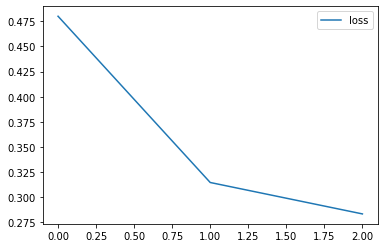

In [89]:
history_lstm_with_recurrent_dropout_df = pd.DataFrame(history_lstm_with_recurrent_dropout.history)
history_lstm_with_recurrent_dropout_df.loc[:, ['loss']].plot()
print(history_lstm_with_recurrent_dropout_df[:4])

LSTM and Convolutional Neural Network for classification

In [79]:
model_lstm_with_cnn = Sequential([
    Embedding(top_words, embedding_vector_lenth, input_length=max_review_length),
    Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(100),
    Dense(1, activation='sigmoid')
])

In [80]:
model_lstm_with_cnn.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')

In [81]:
model_lstm_with_cnn.fit(x_train, y_test, batch_size=64, epochs=3)

Epoch 1/3
391/391 [==============================] - 156s 392ms/step - loss: 0.6934 - accuracy: 0.4972
Epoch 2/3
391/391 [==============================] - 150s 385ms/step - loss: 0.6893 - accuracy: 0.5321
Epoch 3/3
391/391 [==============================] - 163s 417ms/step - loss: 0.6329 - accuracy: 0.6396


In [82]:
scores_2 = model_lstm_with_cnn.evaluate(x_test, y_test, verbose=0) 
print("Accuracy: %.2f%%" % (scores_2[1]*100)) 


Accuracy: 49.97%


In [83]:
model_lstm_with_cnn_with_dropout = Sequential([
    Embedding(top_words, embedding_vector_lenth, input_length=max_review_length),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(100),
    Dense(1, activation='sigmoid')
])

In [84]:
model_lstm_with_cnn_with_dropout.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')

In [85]:
model_lstm_with_cnn_with_dropout.fit(x_train, y_train, epochs=3, batch_size=64)

Epoch 1/3
391/391 [==============================] - 147s 370ms/step - loss: 0.4372 - accuracy: 0.7841
Epoch 2/3
391/391 [==============================] - 145s 370ms/step - loss: 0.2478 - accuracy: 0.9020
Epoch 3/3
391/391 [==============================] - 144s 369ms/step - loss: 0.2170 - accuracy: 0.9174


In [86]:
scores_3 = model_lstm_with_cnn_with_dropout.evaluate(x_test, y_test, verbose=0) 
print("Accuracy: %.2f%%" % (scores_3[1]*100)) 


Accuracy: 88.20%
